# Lab 4: Sequential Data

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: 

# PART A - Spam Detection [30 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Part 1. Data Cleaning [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
for line in open('SMSSpamCollection'):
  if line[0] == "h":

    print(line)
    break

for line in open('SMSSpamCollection'):
  if line[0] == "s":

    print(line)
    break


ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



Spam messages have a label = spam and non spam messages have a label = ham

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
i,j =0,0
for line in open('SMSSpamCollection'):
  if line[0] == "h":
   i += 1
  else:
   j += 1 

print("number of spam messages = ",j)
print("number of non-spam messages = ",i)


number of spam messages =  747
number of non-spam messages =  4827


Number of spam messages are 747 and the number of non spam messages are 4827. There are less spam messages in the dataset.

### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:

The vocabulary required will be smaller for character-level RNN.Therefore it will require less memory.

They do not require tokenization as a preprocessing step.

Disadvantages:

It’s not as good as the word-level RNN at capturing long-distance dependencies.They need to learn spelling in addition to grammar.


The model would have to make more predictions than a word-level RNN which makes it more prone to errors.


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
from torchtext.legacy import datasets
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

TEXT = dataset[0].sms
LABEL = dataset[0].label

train, test = torchtext.legacy.data.Dataset.split(dataset,split_ratio = 0.6,stratified = True,strata_field = 'label')
valid, test = torchtext.legacy.data.Dataset.split(test,split_ratio = 0.5,stratified = True,strata_field = 'label')



In [ ]:
len(list(train))


3343

In [ ]:
len(list(valid))

1115

In [ ]:
len(list(test))


1114

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

Model will overfit on non spam data. Therefore we need to balance the dataset.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
text_field.vocab.stoi
#text_field.vocab.itos

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f98bfae5c90>>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             'o': 4,
             't': 5,
             'a': 6,
             'n': 7,
             'r': 8,
             'i': 9,
             's': 10,
             'l': 11,
             'u': 12,
             'h': 13,
             '0': 14,
             'd': 15,
             '.': 16,
             'c': 17,
             'm': 18,
             'y': 19,
             'w': 20,
             'p': 21,
             'g': 22,
             '1': 23,
             'f': 24,
             'b': 25,
             '2': 26,
             'T': 27,
             '8': 28,
             'k': 29,
             'E': 30,
             'v': 31,
             'S': 32,
             '5': 33,
             'C': 34,
             'O': 35,
             'I': 36,
             '4': 37,
             'N': 38,
             'A': 39,
             '7':

In [ ]:
text_field.vocab.stoi.__len__()

115

.stoi - A collections.defaultdict instance mapping token strings to numerical identifiers.

.itos - A list of token strings indexed by their numerical identifiers.

### Part (g) [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

"unk" is an unknown token which replaces the rare words to unknown token.

"pad" fills in the batches with padding so that each batch is the same length.

### Part (h) [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i =0

for batch in train_iter:
    if i<10:
      print("length of maximum input sequence is:",len(list(batch.sms)[0][0]))
      a,_ = batch.sms
      print("Number of pad tokens in a batch is:",(a==1).sum().item())
      i+=1


length of maximum input sequence is: 69
Number of pad tokens in a batch is: 37
length of maximum input sequence is: 151
Number of pad tokens in a batch is: 34
length of maximum input sequence is: 133
Number of pad tokens in a batch is: 38
length of maximum input sequence is: 159
Number of pad tokens in a batch is: 16
length of maximum input sequence is: 197
Number of pad tokens in a batch is: 533
length of maximum input sequence is: 26
Number of pad tokens in a batch is: 10
length of maximum input sequence is: 157
Number of pad tokens in a batch is: 0
length of maximum input sequence is: 149
Number of pad tokens in a batch is: 0
length of maximum input sequence is: 146
Number of pad tokens in a batch is: 24
length of maximum input sequence is: 28
Number of pad tokens in a batch is: 32


## Part 2. Model Building [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(116)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

In [ ]:
device = torch.device("cuda")

In [ ]:
text_field.build_vocab(train)


In [ ]:
#Model1
class RNN_1(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(RNN_1, self).__init__()
        self.emb = torch.eye(len(text_field.vocab.stoi))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN_1(input_size,hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32,1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        x = x.to(device)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc1(out[:, -1, :]) ###########
        out = self.sig(self.fc2(out))
        return out



In [ ]:
#model2
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.emb = torch.eye(len(text_field.vocab.stoi))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size,hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32,1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        x = x.to(device)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        #out = self.fc1(out[:, -1, :]) ###########
        out = self.fc1(torch.max(out, dim=1)[0])
        out = self.sig(self.fc2(out))
        return out




## Part 3. Training [8 pt]

### Part (a) [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for batch in data_loader:
        batch.label = batch.label.to(device)
        e, _ = batch.sms  
        e = e.to(device)         
        pred = model(e)
        pred = torch.round(pred)
        correct += pred.squeeze().eq(batch.label).sum().item()
        total += batch.label.shape[0]
    return correct / total

### Part (b) [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
from matplotlib import pyplot as plt
def train_rnn_network(model, train, valid, num_epochs=25, learning_rate=1e-4):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    #actual_train = list(train)
    for epoch in range(num_epochs):
        i = 0
        for batch in train:
            optimizer.zero_grad()
            batch.label = batch.label.to(device)
            e , _ = batch.sms  
            e = e.to(device)          
            pred = model(e)
            loss = criterion(pred.squeeze(), batch.label.float())
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
          # plotting

    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,

                                           batch_size=32,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)                  # repeat the iterator for many epochs



valid_iter = torchtext.legacy.data.BucketIterator(valid,

                                           batch_size=32,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)                  # repeat the iterator for many epochs

Epoch 1; Loss 0.666501; Train Acc 0.519980; Val Acc 0.134529
Epoch 2; Loss 0.670698; Train Acc 0.841154; Val Acc 0.780269
Epoch 3; Loss 0.270880; Train Acc 0.919582; Val Acc 0.937220
Epoch 4; Loss 0.355612; Train Acc 0.892555; Val Acc 0.946188
Epoch 5; Loss 0.124861; Train Acc 0.929862; Val Acc 0.943498
Epoch 6; Loss 0.169392; Train Acc 0.944619; Val Acc 0.936323
Epoch 7; Loss 0.249204; Train Acc 0.917095; Val Acc 0.935426
Epoch 8; Loss 0.056009; Train Acc 0.945117; Val Acc 0.939910
Epoch 9; Loss 0.309214; Train Acc 0.951252; Val Acc 0.948879
Epoch 10; Loss 0.244066; Train Acc 0.947438; Val Acc 0.956951
Epoch 11; Loss 0.033861; Train Acc 0.948931; Val Acc 0.946188
Epoch 12; Loss 0.137643; Train Acc 0.934339; Val Acc 0.963229
Epoch 13; Loss 0.733969; Train Acc 0.923562; Val Acc 0.969507
Epoch 14; Loss 0.313156; Train Acc 0.908805; Val Acc 0.923767
Epoch 15; Loss 0.042046; Train Acc 0.955895; Val Acc 0.950673
Epoch 16; Loss 0.032426; Train Acc 0.959708; Val Acc 0.958744
Epoch 17; Loss 0.

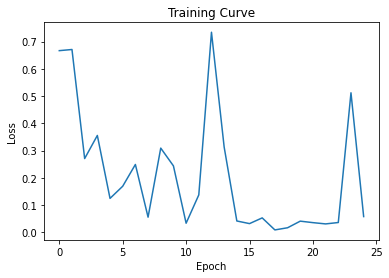

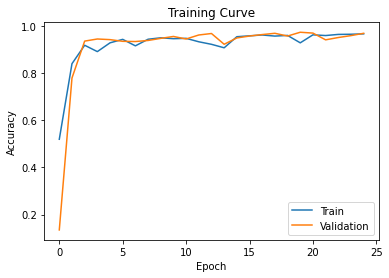

In [ ]:
#MODEL1
model = RNN_1(len(text_field.vocab.stoi),50).to(device) # regular model
train_rnn_network(model, train_iter,valid_iter, num_epochs=25, learning_rate=1e-4)

### Part (c) [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1; Loss 0.643074; Train Acc 0.519980; Val Acc 0.134529
Epoch 2; Loss 0.712932; Train Acc 0.526115; Val Acc 0.143498
Epoch 3; Loss 0.387528; Train Acc 0.853258; Val Acc 0.955157
Epoch 4; Loss 0.400473; Train Acc 0.566407; Val Acc 0.228700
Epoch 5; Loss 0.425286; Train Acc 0.756425; Val Acc 0.586547
Epoch 6; Loss 0.366272; Train Acc 0.934671; Val Acc 0.895067
Epoch 7; Loss 0.292001; Train Acc 0.953407; Val Acc 0.946188
Epoch 8; Loss 0.168447; Train Acc 0.952578; Val Acc 0.938117
Epoch 9; Loss 0.301429; Train Acc 0.952247; Val Acc 0.933632
Epoch 10; Loss 0.393163; Train Acc 0.953739; Val Acc 0.944395
Epoch 11; Loss 0.081122; Train Acc 0.956558; Val Acc 0.946188
Epoch 12; Loss 0.144300; Train Acc 0.959377; Val Acc 0.947085
Epoch 13; Loss 0.087710; Train Acc 0.960371; Val Acc 0.947982
Epoch 14; Loss 0.211413; Train Acc 0.960869; Val Acc 0.945291
Epoch 15; Loss 0.072050; Train Acc 0.960869; Val Acc 0.954260
Epoch 16; Loss 0.079313; Train Acc 0.963024; Val Acc 0.959641
Epoch 17; Loss 0.

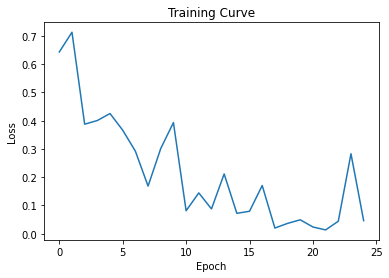

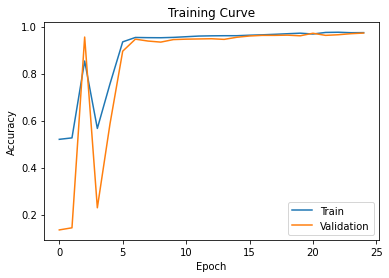

In [ ]:
#MODEL 2
model = RNN(len(text_field.vocab.stoi),50).to(device) # max output model
train_rnn_network(model, train_iter,valid_iter, num_epochs=25, learning_rate=1e-4)
#get_accuracy(model,test_loader)

We can see that the second model performs slightly better

Epoch 1; Loss 0.688295; Train Acc 0.822418; Val Acc 0.798206
Epoch 2; Loss 0.678612; Train Acc 0.536727; Val Acc 0.167713
Epoch 3; Loss 0.717076; Train Acc 0.533245; Val Acc 0.157848
Epoch 4; Loss 0.690670; Train Acc 0.632233; Val Acc 0.347085
Epoch 5; Loss 0.535159; Train Acc 0.933344; Val Acc 0.921973
Epoch 6; Loss 0.582545; Train Acc 0.899519; Val Acc 0.867265
Epoch 7; Loss 0.562952; Train Acc 0.928038; Val Acc 0.953363
Epoch 8; Loss 0.517520; Train Acc 0.934008; Val Acc 0.953363
Epoch 9; Loss 0.328806; Train Acc 0.898524; Val Acc 0.973094
Epoch 10; Loss 0.361704; Train Acc 0.938319; Val Acc 0.967713
Epoch 11; Loss 0.296263; Train Acc 0.948931; Val Acc 0.960538
Epoch 12; Loss 0.084939; Train Acc 0.936329; Val Acc 0.977578
Epoch 13; Loss 0.054383; Train Acc 0.955729; Val Acc 0.934529
Epoch 14; Loss 0.096660; Train Acc 0.963190; Val Acc 0.957848
Epoch 15; Loss 0.182955; Train Acc 0.960703; Val Acc 0.965919
Epoch 16; Loss 0.209679; Train Acc 0.963024; Val Acc 0.967713
Epoch 17; Loss 0.

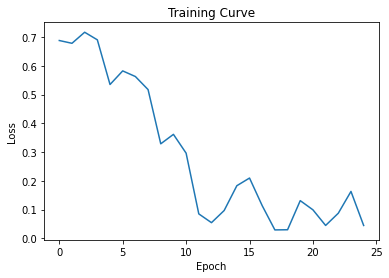

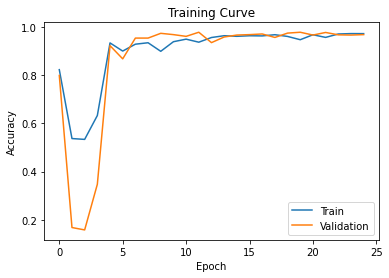

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)                  # repeat the iterator for many epochs



valid_iter = torchtext.legacy.data.BucketIterator(valid,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)                  # repeat the iterator for many epochs
model = RNN(len(text_field.vocab.stoi),50).to(device) # max output model
train_rnn_network(model, train_iter,valid_iter, num_epochs=25, learning_rate=1e-4)

We get slightly better accuracy for a batch size of 64 and 25 epochs.The best accuracy so far is 97.75

Epoch 1; Loss 0.440638; Train Acc 0.930360; Val Acc 0.902242
Epoch 2; Loss 0.116365; Train Acc 0.959211; Val Acc 0.964126
Epoch 3; Loss 0.202328; Train Acc 0.971481; Val Acc 0.957848
Epoch 4; Loss 0.163038; Train Acc 0.973802; Val Acc 0.969507
Epoch 5; Loss 0.512040; Train Acc 0.974134; Val Acc 0.977578
Epoch 6; Loss 0.133581; Train Acc 0.981595; Val Acc 0.973094
Epoch 7; Loss 0.033283; Train Acc 0.983916; Val Acc 0.974888
Epoch 8; Loss 0.246456; Train Acc 0.978776; Val Acc 0.952466
Epoch 9; Loss 0.016736; Train Acc 0.993036; Val Acc 0.979372
Epoch 10; Loss 0.007209; Train Acc 0.992870; Val Acc 0.978475
Epoch 11; Loss 0.004584; Train Acc 0.987233; Val Acc 0.977578
Epoch 12; Loss 0.001774; Train Acc 0.996684; Val Acc 0.979372
Epoch 13; Loss 0.003607; Train Acc 0.998176; Val Acc 0.979372
Epoch 14; Loss 0.010192; Train Acc 0.996352; Val Acc 0.980269
Epoch 15; Loss 0.000517; Train Acc 0.996352; Val Acc 0.980269
Epoch 16; Loss 0.015077; Train Acc 0.999834; Val Acc 0.978475
Epoch 17; Loss 0.

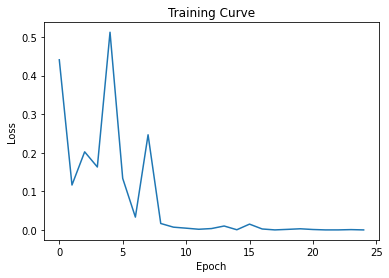

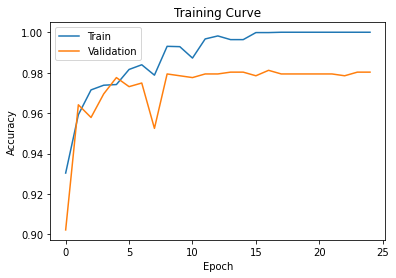

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)                  # repeat the iterator for many epochs



valid_iter = torchtext.legacy.data.BucketIterator(valid,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)                  # repeat the iterator for many epochs
model = RNN(len(text_field.vocab.stoi),50).to(device) # max output model
train_rnn_network(model, train_iter,valid_iter, num_epochs=25, learning_rate=1e-3)

Increasing the learning rate gave us better accuracy.

Epoch 1; Loss 0.115662; Train Acc 0.808489; Val Acc 0.961435
Epoch 2; Loss 0.047110; Train Acc 0.958050; Val Acc 0.971300
Epoch 3; Loss 0.093745; Train Acc 0.965014; Val Acc 0.964126
Epoch 4; Loss 0.207335; Train Acc 0.973305; Val Acc 0.971300
Epoch 5; Loss 0.010883; Train Acc 0.974631; Val Acc 0.976682
Epoch 6; Loss 0.065281; Train Acc 0.962527; Val Acc 0.980269
Epoch 7; Loss 0.015247; Train Acc 0.985740; Val Acc 0.977578
Epoch 8; Loss 0.004876; Train Acc 0.985243; Val Acc 0.979372
Epoch 9; Loss 0.282785; Train Acc 0.989886; Val Acc 0.968610
Epoch 10; Loss 0.035232; Train Acc 0.996186; Val Acc 0.978475
Epoch 11; Loss 0.033355; Train Acc 0.999005; Val Acc 0.985650
Epoch 12; Loss 0.005834; Train Acc 0.999668; Val Acc 0.982960


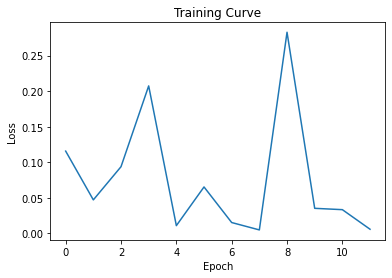

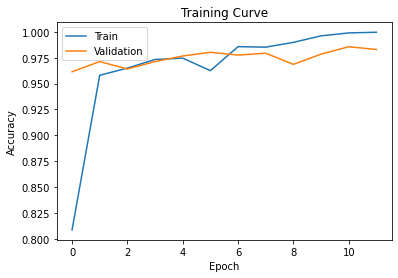

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)                  # repeat the iterator for many epochs



valid_iter = torchtext.legacy.data.BucketIterator(valid,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)                  # repeat the iterator for many epochs
model = RNN(len(text_field.vocab.stoi),100).to(device) # max output model
train_rnn_network(model, train_iter,valid_iter, num_epochs=12, learning_rate=1e-3)

So, using the second model, batchsize of 64, learning rate of 1e-3, epochs =12 and adjusting the hiddensize to 100, we get the best model.

### Part (d) [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [ ]:

valid_iter_spam = torchtext.legacy.data.BucketIterator(valid_spam,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)  

In [ ]:
get_accuracy(model,valid_iter_spam)

0.94

False positive rate of our model is 0.06

In [ ]:

valid_iter_nospam = torchtext.legacy.data.BucketIterator(valid_nospam,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)  

In [ ]:
get_accuracy(model,valid_iter_nospam)

0.9906735751295337

False negative rate of our model is 0.0094

### Part (e) [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False positive will anger the user. If its not spam and we classify it as spam the user might miss out on an important message.

False negative wouldn't matter much to the user as we have just incorrectly classified spam as non spam and they can always ignore it.

## Part 4. Evaluation [7 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_iter = torchtext.legacy.data.BucketIterator(test,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)  
get_accuracy(model,test_iter)

0.9874326750448833

### Part (b) [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)
test_iter_nospam = torchtext.legacy.data.BucketIterator(test_nospam,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)
test_iter_spam = torchtext.legacy.data.BucketIterator(test_spam,

                                           batch_size=64,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False)

In [ ]:
get_accuracy(model,test_iter_nospam)

0.9927461139896373

In [ ]:
get_accuracy(model,test_iter_spam)

0.9463087248322147

In [ ]:
#Confusion matrix

valid_iter = torchtext.legacy.data.BucketIterator(valid,

                                           batch_size=1,

                                           sort_key=lambda x: len(x.sms), # to minimize padding

                                           sort_within_batch=True,        # sort within each batch

                                           repeat=False) 
pred_list=[]
actual_list=[]
correct, total = 0, 0
for batch in valid_iter:
    batch.label = batch.label.to(device)
    e, _ = batch.sms  
    e = e.to(device)         
    pred = model(e)
    pred = torch.round(pred)
    pred_list.append(int(pred.item()))
    actual_list.append(batch.label.item())

pred_list = torch.tensor((np.array(pred_list)))
actual_list = torch.tensor((np.array(actual_list)))

In [ ]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
matrix = ConfusionMatrix(num_classes =2)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 37.6 MB/s 


/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.7/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


tensor([[953,  12],
        [  8, 142]])

In [ ]:
confusion_model_1 = matrix(pred_list,actual_list)

In [ ]:
confusion_model_1

tensor([[953,  12],
        [  8, 142]])

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

In [ ]:
def msg_array(msg):
  msg_new = msg = list(msg)
  msg = [ch for ch in msg]
  index = []
  for ch in msg:
    for a in text_field.vocab.stoi.keys():
      if ch == a:
        index.append(text_field.vocab.stoi[a])
  return index


In [ ]:
ind = msg_array(msg)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
output = torch.round(output)
output.item()

0.0

Our model tells us that the message is not spam and the probability is 0.0021(calculated at a later section of the file)

### Part (d) [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Spam detection is not an easy task as there can always be new ways to create spam messages.

A simple neural network for the baseline model would be as follows

The first layer is the input layer which has 50 nodes, 1 node for each feature of the email

The second layer is the middle layer which has 4 node

The final layer is the output layer which has just 1 node

The input layer takes in the 50 features of the email as a vector and passes it to the middle layer. Finally, the output layer outputs a real number in the interval (0, 1) which in some sense serves as a probability of the mail being a spam.


# PART B - Transfer Learning [20 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [ ]:
# install relevant libraries
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [ ]:
!pip install spacy==2.3.5
!pip install fastai==1.0.61
# load relevant libraries
from fastai import *
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2022-11-21 04:34:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   304KB/s    in 0.7s    

2022-11-21 04:34:03 (304 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: SMSSpamCollection       
  inflating: readme                  


This time we will load the data using pandas.

In [ ]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [ ]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [ ]:
df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [ ]:
# create pretrained language model data

data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

lang_mod = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [ ]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when it looks like a mad Christmas . At
The problem usually starts when the player is at the main end of a city
The problem usually starts when you need to watch fast enough to make clean or
The problem usually starts when the largest all of the people in the monthly months
The problem usually starts when the main is in " The Last


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [ ]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.567632,3.994498,0.285714,00:02
1,4.834749,3.877780,0.257143,00:02
2,4.380589,3.881617,0.257143,00:02
3,4.052392,3.826882,0.257143,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.571272,3.810156,0.257143,00:02
1,3.540520,3.802537,0.257143,00:02
2,3.475986,3.774877,0.242857,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.400034,3.790210,0.257143,00:02
1,3.374001,3.786584,0.242857,00:02
2,3.361855,3.780725,0.242857,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.352563,3.784400,0.242857,00:03
1,3.293655,3.810270,0.242857,00:03
2,3.252882,3.802187,0.257143,00:04


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data_clas.show_batch()

text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! !",ham
"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! !",ham
xxbos xxmaj how to xxmaj make a girl xxmaj happy ? xxmaj it 's not at all difficult to make girls happy . u only need to be ... 1 . a friend 2 . xxmaj xxunk 3 . xxmaj lover 4 . xxmaj xxunk . . . < # > . xxmaj good xxunk < # > . xxmaj xxunk < # > . xxmaj good boyfriend < #,ham
"xxbos < # > is fast xxunk . xxmaj so , xxmaj wish u a very xxmaj happy xxmaj new xxmaj year xxmaj happy xxmaj xxunk xxmaj happy xxunk day xxmaj happy xxmaj valentines xxmaj day xxmaj happy xxmaj xxunk xxmaj happy xxmaj xxunk xxmaj happy xxmaj xxunk day xxmaj happy xxmaj may xxmaj day xxmaj happy xxmaj xxunk xxmaj day , xxmaj happy xxmaj friendship , xxmaj mother ,",ham


In [ ]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [ ]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3900 items)
x: TextList
xxbos i liked your new house,xxbos xxmaj xxunk i 'm walking in xxunk now ü faster come down ... xxmaj me very hungry ...,xxbos xxmaj wan2 win a meet+greet with xxmaj westlife 4 u or a m8 ? xxmaj they are currently on what tour ? 1)unbreakable , 2)untamed , 3)unkempt . xxmaj text 1,2 or 3 to 83049 . xxmaj cost 50p + std text,xxbos xxmaj otherwise had part time job na - tuition ..,xxbos xxmaj wait , do you know if xxunk in town ? i bet she does hella drugs !
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1672 items)
x: TextList
xxbos xxmaj not a lot has happened here . xxmaj feels very xxunk . xxmaj xxunk is at her xxunk and xxunk is working lots . xxmaj just me and xxunk in at the mo . xxmaj how have you been ?,xxbos xxmaj the current xxunk bid is xxunk . xxmaj to xxunk this auction send xxup out . xxmaj customer xxmaj care : xxunk,xxbos xxmaj are you free xxunk i call now ?,xxbos xxmaj cold 

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 1.74E-02


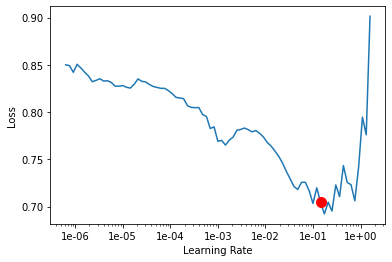

In [ ]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.407212,0.070540,0.977871,00:03
1,0.203867,0.073522,0.986842,00:03
2,0.115671,0.058068,0.986842,00:03
3,0.095909,0.070845,0.983254,00:03
4,0.077953,0.079577,0.980861,00:03


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

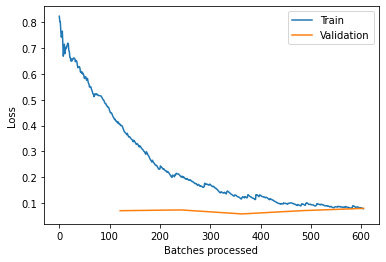

In [ ]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


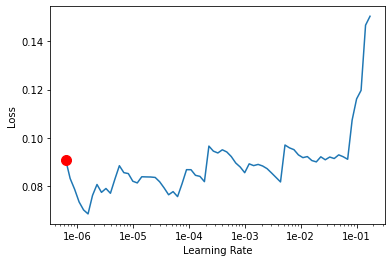

In [ ]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [ ]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([9.9957e-01, 4.3219e-04]))

In [ ]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(1), tensor(1), tensor([0.4046, 0.5954]))

Next we will evaluate on all of our validation data.

In [ ]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1672, 2])

## Part 1. Evaluate Performance [10pt]

### Part (a) [5pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

In [ ]:
valid_preds[0]

tensor([9.9972e-01, 2.8017e-04])

In [ ]:
valid_pred_list=[]
for i in valid_preds:
  _,j = torch.max(i,dim =0)
  valid_pred_list.append(j.item())

valid_pred_list = torch.tensor(np.array(valid_pred_list))

In [ ]:
correct, total = 0,0
for i in range(len(valid_preds)):
  correct += valid_pred_list.eq(valid_label).sum().item()
  total+= valid_label.shape[0]
validation_acc = correct/total

In [ ]:
validation_acc

0.9808612440191388

ULMfit model has achieved 98% accuracy. ULMfit gives us similar accuracy to the LSTM model for the validation set. We would have to look at the confusion matrix for further inspection.

### Part (b) [5pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 22.5 MB/s 


In [ ]:
from torchmetrics import ConfusionMatrix
matrix = ConfusionMatrix(num_classes =2)
matrix(valid_pred_list,valid_label)

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


tensor([[1448,    0],
        [  32,  192]])

In [ ]:
confusion_model_1

tensor([[953,  12],
        [  8, 142]])

Our initial model misclassifies less of the spam messages compared to our umfit model.Umfit has classified all the non spam messages correctly. This means that the umfit would be better as incorrectly classifying non spam messages as spam would mean that the user might miss out on important messages.

## Part 2. Evaluate on New Data [10pt]

### Part (a) [4pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [ ]:
ind = msg_array(msg)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_1 = output.item()
print("probability of msg by model 1 =",mod1_1)

probability of msg by model 1 = 0.0021182680502533913


In [ ]:
msg = "machine learning is sooo cool!"
learn_classifier.predict(msg)

(Category tensor(0), tensor(0), tensor([1.0000e+00, 2.4702e-11]))

The model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam is 2.4702e-11

### Part (b) [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

In [ ]:
msg1 = "your smart home security offer free installation"
msg2 = "Take this quiz to find your perfect frames"
msg3 = "Clinically Proven , Outrageously Effective Whole Body Deodorant"
msg4 = "Hurry up! Registration open for Company Secretary Executive Entrance Test"
msg5 = "Loan Disbursal in 30 mins"

In [ ]:
def msg_array(msg):
  msg_new = msg = list(msg)
  msg = [ch for ch in msg]
  index = []
  for ch in msg:
    for a in text_field.vocab.stoi.keys():
      if ch == a:
        index.append(text_field.vocab.stoi[a])
  return index

ind = msg_array(msg1)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_1 = output.item()
print("probability of msg1 by model 1 =",mod1_1)

ind = msg_array(msg2)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_2 = output.item()
print("probability of msg2 by model 1 =",mod1_2)


ind = msg_array(msg3)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_3 = output.item()
print("probability of msg3 by model 1 =",mod1_3)

ind = msg_array(msg4)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_4 = output.item()
print("probability of msg4 by model 1 =",mod1_4)


ind = msg_array(msg5)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_5 = output.item()
print("probability of msg5 by model 1 =",mod1_5)


probability of msg1 by model 1 = 0.027522165328264236
probability of msg2 by model 1 = 0.004551276098936796
probability of msg3 by model 1 = 0.02776477113366127
probability of msg4 by model 1 = 0.0324937142431736
probability of msg5 by model 1 = 0.0123796621337533


In [ ]:
print(learn_classifier.predict(msg1))
print(learn_classifier.predict(msg2))
print(learn_classifier.predict(msg3))
print(learn_classifier.predict(msg4))
print(learn_classifier.predict(msg5))

(Category tensor(0), tensor(0), tensor([0.9448, 0.0552]))
(Category tensor(0), tensor(0), tensor([0.9939, 0.0061]))
(Category tensor(0), tensor(0), tensor([0.9799, 0.0201]))
(Category tensor(0), tensor(0), tensor([0.8755, 0.1245]))
(Category tensor(0), tensor(0), tensor([0.7111, 0.2889]))


Both the model do not perform well on spam messages.

### Part (c) [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

In [ ]:
msg1 = "My recovery seems like it will take more time than I was anticipating so I'm giving up my shift"
msg2 = "I can do it if it's still available "
msg3 = "Unfortunately, I won't be able to work"
msg4 = "Great! See you then!"
msg5 = "Let me know if you can't make a 2pm start time"

In [ ]:
def msg_array(msg):
  msg_new = msg = list(msg)
  msg = [ch for ch in msg]
  index = []
  for ch in msg:
    for a in text_field.vocab.stoi.keys():
      if ch == a:
        index.append(text_field.vocab.stoi[a])
  return index

ind = msg_array(msg1)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_1 = output.item()
print("probability of msg1 by model 1 =",mod1_1)

ind = msg_array(msg2)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_2 = output.item()
print("probability of msg2 by model 1 =",mod1_2)


ind = msg_array(msg3)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_3 = output.item()
print("probability of msg3 by model 1 =",mod1_3)

ind = msg_array(msg4)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_4 = output.item()
print("probability of msg4 by model 1 =",mod1_4)


ind = msg_array(msg5)
ind = torch.tensor(np.array(ind))
ind = ind[None,:]
output= model(ind)
#output = torch.round(output)
mod1_5 = output.item()
print("probability of msg5 by model 1 =",mod1_5)


probability of msg1 by model 1 = 0.0007693347288295627
probability of msg2 by model 1 = 6.891010707477108e-05
probability of msg3 by model 1 = 0.0014235894195735455
probability of msg4 by model 1 = 0.0006270520389080048
probability of msg5 by model 1 = 0.0014025424607098103


In [ ]:
print(learn_classifier.predict(msg1))
print(learn_classifier.predict(msg2))
print(learn_classifier.predict(msg3))
print(learn_classifier.predict(msg4))
print(learn_classifier.predict(msg5))

(Category tensor(0), tensor(0), tensor([1.0000e+00, 8.5534e-12]))
(Category tensor(0), tensor(0), tensor([1.0000e+00, 8.5249e-12]))
(Category tensor(0), tensor(0), tensor([1.0000e+00, 1.0924e-10]))
(Category tensor(0), tensor(0), tensor([9.9998e-01, 1.7070e-05]))
(Category tensor(0), tensor(0), tensor([9.9992e-01, 7.5908e-05]))


Both model perform well when classifying non spam messages.

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html LAB_4_Sequential_Data.ipynb

[NbConvertApp] Converting notebook LAB_4_Sequential_Data.ipynb to html
[NbConvertApp] Writing 756615 bytes to LAB_4_Sequential_Data.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus